<a href="https://colab.research.google.com/github/hanaahammad/HH_ML_ZOOMCAMP/blob/main/_PyTorch_ML_Zoomcamp_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the Data

In [1]:
#!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip


--2025-12-04 11:57:21--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-04T12%3A45%3A30Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-04T11%3A45%3A08Z&ske=2025-12-04T12%3A45%3A30Z&sks=b&skv=2018-11-09&sig=Irpn0r2dXfRmvzhTl2AafEUdqVZx9JallZg5od57wbw%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDg1MTI0MiwibmJmIjoxNzY0ODQ5NDQyLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG

In [2]:
!unzip data.zip


Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/curly/
  inflating: data/test/curly/03312ac556a7d003f7570657f80392c34.jpg  
  inflating: data/test/curly/106dfcf4abe76990b585b2fc2e3c9f884.jpg  
  inflating: data/test/curly/1a9dbe23a0d95f1c292625960e4509184.jpg  
  inflating: data/test/curly/341ea26e6677b655f8447af56073204a4.jpg  
  inflating: data/test/curly/61aPFVrm42L._SL1352_.jpg  
  inflating: data/test/curly/6d8acb0fe980774ea4e5631198587f45.png  
  inflating: data/test/curly/7f5649a0c33a2b334f23221a52c16b9b.jpg  
  inflating: data/test/curly/90146673.jpg  
  inflating: data/test/curly/9b3608e01d78fbabc9fb0719323d507f4.jpg  
  inflating: data/test/curly/b171c99161f3cffc12d4b74488ef2fc6.jpg  
  inflating: data/test/curly/blogger_one.jpg  
  inflating: data/test/curly/c03ca1590aa4df74e922ad8257305a2b.jpg  
  inflating: data/test/curly/c1b89bb4f86a3478ec20ce1f63f003c1.jpg  
  inflating: data/test/curly/c5.jpg  
  inflating: data/test/curly/C86_76156

# IMPORTS

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np


# Reproducibility

In [3]:
import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# check the device

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Dataset + DataLoader

In [6]:
import os

print(os.listdir('.'))  # what folders exist in current directory?
print(os.listdir('data'))  # what is inside "data"?


['.config', 'data', 'data.zip', 'sample_data']
['train', 'test']


In [7]:
# Transforms for images
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),             # -> (3, 200, 200)
])

# Datasets
train_dataset = datasets.ImageFolder('data/train', transform=transform)
test_dataset  = datasets.ImageFolder('data/test',  transform=transform)

print("Classes:", train_dataset.classes)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)



Classes: ['curly', 'straight']


# Model

In [10]:
class HairCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Conv layer: 3 -> 32, kernel 3x3, stride 1, padding 0
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0
        )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compute flattened size automatically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 200, 200)
            x = self.pool(self.relu(self.conv1(dummy)))  # (1, 32, 99, 99)
            self.flattened_size = x.view(1, -1).shape[1]

        # FC: flattened -> 64 -> 1
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)

        # Output activation (binary classification)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)       # flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.out_act(x)             # probability in [0, 1]
        return x

model = HairCNN().to(device)
print("Flattened size:", model.flattened_size)


Flattened size: 313632


# 4️⃣ Loss function + optimizer

In [11]:
criterion = nn.BCELoss()  # for binary classification with sigmoid output

optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)


# Training loop (train on train_loader, validate on test_loader)

In [12]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)   # (batch_size, 1)

        optimizer.zero_grad()

        outputs = model(images)              # (batch_size, 1), probs in [0,1]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # --- evaluate on test set each epoch ---
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            preds = (outputs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train loss: {avg_train_loss:.4f} | "
        f"Test loss: {avg_test_loss:.4f} | "
        f"Test acc: {test_acc:.4f}"
    )


Epoch [1/5] Train loss: 0.6784 | Test loss: 0.6602 | Test acc: 0.6020
Epoch [2/5] Train loss: 0.6300 | Test loss: 0.7764 | Test acc: 0.5473
Epoch [3/5] Train loss: 0.5952 | Test loss: 0.8741 | Test acc: 0.5622
Epoch [4/5] Train loss: 0.6368 | Test loss: 0.6368 | Test acc: 0.6169
Epoch [5/5] Train loss: 0.5809 | Test loss: 0.6182 | Test acc: 0.6418


# Question 1

Which loss function you will use?

- nn.MSELoss()
- **nn.BCEWithLogitsLoss()**
- nn.CrossEntropyLoss()
- nn.CosineEmbeddingLoss()

# Question 2

In [13]:
# Option 1: Using torchsummary (install with: pip install torchsummary)
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

# Option 2: Manual counting
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
           Sigmoid-7                    [-1, 1]               0
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------
Total parameters: 20073473


# Question 3

##  Transforms and DataLoaders

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# ---- Reproducibility (from earlier) ----
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Transforms (homework spec) ----
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std=[0.229, 0.224, 0.225]     # ImageNet std
    )
])

test_transforms = train_transforms  # same for test

# ---- Datasets ----
train_dataset = datasets.ImageFolder('data/train', transform=train_transforms)
validation_dataset = datasets.ImageFolder('data/test',  transform=test_transforms)

print("Classes:", train_dataset.classes)

# ---- DataLoaders (batch_size=20, shuffle as specified) ----
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)


Using device: cpu
Classes: ['curly', 'straight']


## Model

In [15]:
class HairCNN_Logits(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # compute flattened size automatically
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 200, 200)
            x = self.pool(self.relu(self.conv1(dummy)))  # (1, 32, 99, 99)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 1)   # 1 logit output

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # logits (NO sigmoid here)
        return x

model = HairCNN_Logits().to(device)
print("Flattened size:", model.flattened_size)


Flattened size: 313632


## Loss and optimizers

In [16]:
criterion = nn.BCEWithLogitsLoss()  # expects raw logits
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)


## Training loop

In [17]:
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)              # logits
        loss = criterion(outputs, labels)    # BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # For accuracy, apply sigmoid then threshold
        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # ---- Validation (on test set) ----
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)              # logits
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )


Epoch 1/10, Loss: 0.6462, Acc: 0.6362, Val Loss: 0.6032, Val Acc: 0.6517
Epoch 2/10, Loss: 0.5475, Acc: 0.7100, Val Loss: 0.7251, Val Acc: 0.6318
Epoch 3/10, Loss: 0.5533, Acc: 0.7250, Val Loss: 0.5991, Val Acc: 0.6716
Epoch 4/10, Loss: 0.4802, Acc: 0.7712, Val Loss: 0.6033, Val Acc: 0.6567
Epoch 5/10, Loss: 0.4334, Acc: 0.8025, Val Loss: 0.6196, Val Acc: 0.6766
Epoch 6/10, Loss: 0.3740, Acc: 0.8325, Val Loss: 0.7371, Val Acc: 0.6766
Epoch 7/10, Loss: 0.2721, Acc: 0.8838, Val Loss: 0.9223, Val Acc: 0.6418
Epoch 8/10, Loss: 0.2478, Acc: 0.9000, Val Loss: 0.7294, Val Acc: 0.7214
Epoch 9/10, Loss: 0.2075, Acc: 0.9200, Val Loss: 0.7523, Val Acc: 0.7015
Epoch 10/10, Loss: 0.1494, Acc: 0.9450, Val Loss: 0.7893, Val Acc: 0.7015


## Compute the median training accuracy

In [21]:
train_accs = np.array(history['acc'])
median_train_acc = np.median(train_accs)
print("Training accuracies:", train_accs)
print("Median training accuracy:", median_train_acc)


Training accuracies: [0.63625 0.71    0.725   0.77125 0.8025  0.8325  0.88375 0.9     0.92
 0.945  ]
Median training accuracy: 0.8175


In [24]:
history['acc']

[0.63625, 0.71, 0.725, 0.77125, 0.8025, 0.8325, 0.88375, 0.9, 0.92, 0.945]

## Visualize the results (accuracy & loss curves)

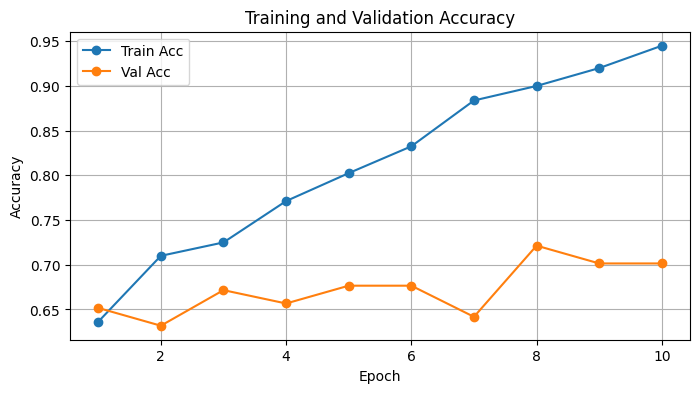

In [22]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, history['acc'], marker='o', label='Train Acc')
plt.plot(epochs, history['val_acc'], marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Loss plot

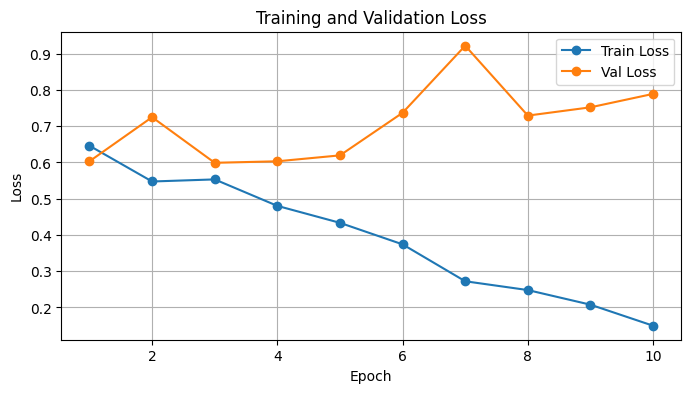

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, history['loss'], marker='o', label='Train Loss')
plt.plot(epochs, history['val_loss'], marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Median calculation

In [25]:
hh= [0.63625, 0.71, 0.725, 0.77125, 0.8025, 0.8325, 0.88375, 0.9, 0.92, 0.945]

In [26]:
median = ( 0.8025+0.8325)/2

In [27]:
median

0.8175

# Question 4

What is the standard deviation of training loss for all the epochs for this model?
- 0.007
- 0.078
- **0.171**
- 1.710


In [29]:
hl = history['loss']

In [30]:
import numpy as np
# Your training loss values
losses = np.array(hl)

# Mean loss
mean_loss = np.mean(losses)

# Variance (population variance: divide by N)
variance_loss = np.var(losses)

# Standard deviation (population)
std_loss = np.std(losses)

print("Loss values:", losses)
print("Mean:", mean_loss)
print("Variance:", variance_loss)
print("Standard deviation:", std_loss)


Loss values: [0.64622589 0.54751014 0.55327745 0.48020912 0.43338784 0.37400239
 0.27212329 0.24781035 0.20747392 0.14940189]
Mean: 0.39114222878590227
Variance: 0.02526997816013863
Standard deviation: 0.1589653363477039


=== Training Accuracy ===
Accuracies: [0.63625 0.71    0.725   0.77125 0.8025  0.8325  0.88375 0.9     0.92
 0.945  ]
Median: 0.8175
Mean: 0.812625
Std: 0.09657809340114352

=== Training Loss ===
Losses: [0.64622589 0.54751014 0.55327745 0.48020912 0.43338784 0.37400239
 0.27212329 0.24781035 0.20747392 0.14940189]
Mean: 0.39114222878590227
Std: 0.1589653363477039



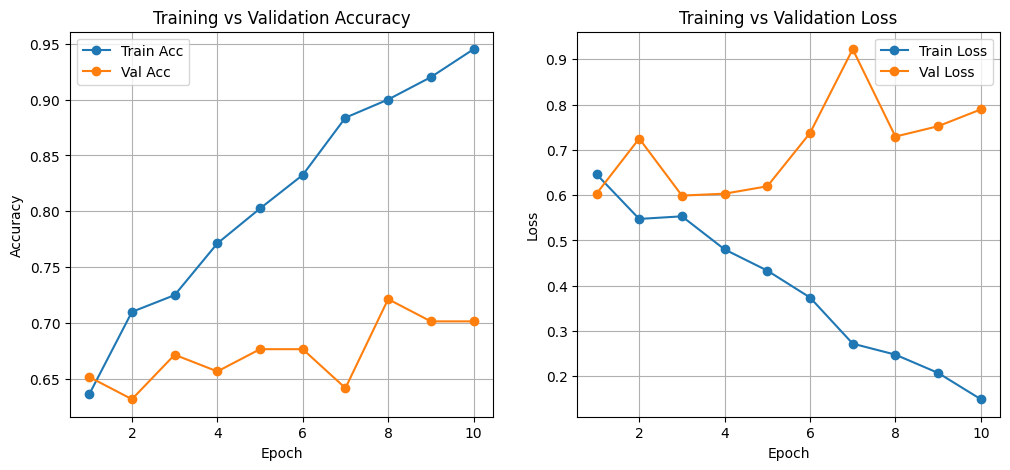

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1. NUMERIC SUMMARY
# -------------------------------------------------------------

# Convert lists to numpy arrays
train_acc = np.array(history['acc'])
val_acc   = np.array(history['val_acc'])
train_loss = np.array(history['loss'])
val_loss   = np.array(history['val_loss'])

# --- Accuracy statistics ---
median_train_acc = np.median(train_acc)
mean_train_acc = np.mean(train_acc)
std_train_acc = np.std(train_acc)

# --- Loss statistics ---
mean_train_loss = np.mean(train_loss)
std_train_loss = np.std(train_loss)

print("=== Training Accuracy ===")
print("Accuracies:", train_acc)
print("Median:", median_train_acc)
print("Mean:", mean_train_acc)
print("Std:", std_train_acc)
print()

print("=== Training Loss ===")
print("Losses:", train_loss)
print("Mean:", mean_train_loss)
print("Std:", std_train_loss)
print()

# -------------------------------------------------------------
# 2. VISUALIZATION: ACCURACY CURVE
# -------------------------------------------------------------

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, marker='o', label='Train Acc')
plt.plot(epochs, val_acc, marker='o', label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()

# -------------------------------------------------------------
# 3. VISUALIZATION: LOSS CURVE
# -------------------------------------------------------------

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

plt.show()


# Augmentation

### Add data augmentation to the training transforms

In [33]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# augmented transforms for TRAIN
train_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(
        200,
        scale=(0.9, 1.0),
        ratio=(0.9, 1.1)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# SAME transforms for TEST as before (no augmentation!)
test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


### rebuild train

In [34]:
# Recreate train dataset with *augmented* transforms
train_dataset = datasets.ImageFolder('data/train', transform=train_transforms)
validation_dataset = datasets.ImageFolder('data/test',  transform=test_transforms)

# New loaders: batch_size = 20, shuffle as specified
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)

print("Classes:", train_dataset.classes)


Classes: ['curly', 'straight']


### Train 10 more epochs

In [35]:
num_epochs = 10  # 10 more epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)              # logits
        loss = criterion(outputs, labels)    # BCEWithLogitsLoss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        predicted = (probs > 0.5).float()

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    # ---- validation on test set ----
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(
        f"Epoch {len(history['acc'])}/{len(history['acc'])}, "
        f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
        f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"
    )


Epoch 11/11, Loss: 0.6833, Acc: 0.6613, Val Loss: 0.6683, Val Acc: 0.6866
Epoch 12/12, Loss: 0.5497, Acc: 0.7175, Val Loss: 0.7346, Val Acc: 0.7015
Epoch 13/13, Loss: 0.5276, Acc: 0.7362, Val Loss: 0.6140, Val Acc: 0.7015
Epoch 14/14, Loss: 0.5029, Acc: 0.7525, Val Loss: 0.5711, Val Acc: 0.7015
Epoch 15/15, Loss: 0.5020, Acc: 0.7650, Val Loss: 0.6148, Val Acc: 0.6866
Epoch 16/16, Loss: 0.4804, Acc: 0.7700, Val Loss: 0.5357, Val Acc: 0.7313
Epoch 17/17, Loss: 0.4758, Acc: 0.7588, Val Loss: 0.5772, Val Acc: 0.7164
Epoch 18/18, Loss: 0.4662, Acc: 0.7725, Val Loss: 0.5366, Val Acc: 0.7363
Epoch 19/19, Loss: 0.4401, Acc: 0.7963, Val Loss: 0.6774, Val Acc: 0.6368
Epoch 20/20, Loss: 0.4421, Acc: 0.7913, Val Loss: 0.5120, Val Acc: 0.7612


### Compute the mean test loss for the augmented training

In [36]:
import numpy as np

# Last 10 validation losses = with augmentations
val_losses_aug = np.array(history['val_loss'][-10:])
mean_val_loss_aug = val_losses_aug.mean()

print("Validation losses with augmentation:", val_losses_aug)
print("Mean validation (test) loss with augmentation:", mean_val_loss_aug)


Validation losses with augmentation: [0.66828588 0.73459128 0.61402166 0.57112057 0.61476142 0.53567465
 0.5772467  0.5365504  0.67743178 0.51197812]
Mean validation (test) loss with augmentation: 0.6041662467949426


# Question 5
Let's train our model for 10 more epochs using the same code as previously.

Note: make sure you don't re-create the model. we want to continue training the model we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

- 0.008
- 0.08
- **0.88**
- 8.88


In [37]:
import numpy as np

# history['val_loss'] should now contain 20 values:
# - first 10: before augmentation
# - last 10: after augmentation (what we need)

# Extract the last 10 validation losses (augmentation phase)
val_losses_aug = np.array(history['val_loss'][-10:])

# Compute the mean
mean_val_loss_aug = val_losses_aug.mean()

print("Validation losses with augmentation:", val_losses_aug)
print("Mean validation (test) loss with augmentation:", mean_val_loss_aug)


Validation losses with augmentation: [0.66828588 0.73459128 0.61402166 0.57112057 0.61476142 0.53567465
 0.5772467  0.5365504  0.67743178 0.51197812]
Mean validation (test) loss with augmentation: 0.6041662467949426


# Question 6
What's the average of test accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?

- 0.08
- 0.28
- **0.68**
- 0.98


In [38]:
#Code to calculate mean accuracy for epochs 6–10 (augmentation phase)
import numpy as np

# history['val_acc'] should have 20 values total
# first 10 -> before augmentation
# last 10  -> augmentation training

val_acc_aug = np.array(history['val_acc'][-10:])  # last 10 epochs

# We want epochs 6–10 → last 5 values:
last5_val_acc = val_acc_aug[-5:]

mean_last5_val_acc = last5_val_acc.mean()

print("Validation accuracy last 10 (augmentation):", val_acc_aug)
print("Validation accuracy last 5 (epochs 6–10):", last5_val_acc)
print("Mean of last 5 validation accuracies:", mean_last5_val_acc)


Validation accuracy last 10 (augmentation): [0.68656716 0.70149254 0.70149254 0.70149254 0.68656716 0.73134328
 0.71641791 0.73631841 0.63681592 0.76119403]
Validation accuracy last 5 (epochs 6–10): [0.73134328 0.71641791 0.73631841 0.63681592 0.76119403]
Mean of last 5 validation accuracies: 0.7164179104477612
